<a id="topL"></a>

# Working with the COS Line Spread Function

# Learning Goals
### This Notebook is designed to walk the user (*you*) through: **Working with the COS Line Spread Function(LSF) to simulate, fit, or model COS observations**
   #### 1. [**Understanding the Line Spread Function**](#undL)
   ##### - 1.1. [What is an LSF?](#whatL)
   ##### - 1.2. [Getting the files you need](#whichL)

   #### 2. [**Taking a look at the LSF kernels**](#lookL)
   ##### - 2.1. [Reading in an LSF](#readL)
   ##### - 2.2. [Plotting an LSF kernel](#plotL)

   #### 3. [**Convolving an LSF**](#convL)
   ##### - 3.1. [Defining some functions for LSF convolution](#funcL)
   ###### + 3.1.1 [`get_disp_params`: Getting the dispersion relationship parameters](#fndispL)
   ###### + 3.1.2 [`redefine_lsf`: Redefining the LSF in terms of wavelength](#fnredefL)
   ###### + 3.1.3 [`convolve_lsf`: Applying the convolution](#fnconvL)
   ##### - 3.2. [Convolving simple line profiles](#picketL)
   ##### - 3.3. [Convolving real data from STIS](#stisL)



# 0. Introduction
#### The Cosmic Origins Spectrograph ([*COS*](https://www.nasa.gov/content/hubble-space-telescope-cosmic-origins-spectrograph)) is an ultraviolet spectrograph on-board the Hubble Space Telescope([*HST*](https://www.stsci.edu/hst/about)) with capabilities in the near ultraviolet (*NUV*) and far ultraviolet (*FUV*).

#### This tutorial aims to prepare you to work with the COS data of your choice by walking you through convolving a template or high-resolution spectrum with the COS LSF. Note that at present, this notebook does not support working with NUV data.

- For an in-depth manual to working with COS data and a discussion of caveats and user tips, see the [COS Data Handbook](https://hst-docs.stsci.edu/display/COSDHB/).
- For a detailed overview of the COS instrument, see the [COS Instrument Handbook](https://hst-docs.stsci.edu/display/COSIHB/).


## We will import the following packages:

- `numpy` to handle arrays and functions
- `astropy.io fits` and `astropy.table Table` for accessing FITS files
- `astropy.modeling functional_models` to generate synthetic spectral line shapes
- `astropy.convolution convolve` for a convolution of two discretized functions
<!-- - glob, os, and shutil for working with system files -->
- `astroquery.mast Mast` and `Observations` for finding and downloading data from the [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) archive
- `scipy.interpolate interp1d` for interpolating two discretized functions to the same sampling
- `matplotlib.pyplot` for plotting
- `urllib` for downloading files stored at a web address online

These python packages are installed standard with the the STScI conda distribution. For more information, see our notebook tutorial on [setting up an environment](https://github.com/spacetelescope/COS-Notebooks/blob/master/Setup/Setup.ipynb).

In [1]:
# for array manipulation
import numpy as np
# for reading fits files
from astropy.table import Table
from astropy.io import fits
# For line profile functions
from astropy.modeling import functional_models
# For convolutions
from astropy.convolution import convolve
# For downloading the data
from astroquery.mast import Observations
# Interpolating a discretized function
from scipy.interpolate import interp1d
# Plotting
from matplotlib import pyplot as plt
# To download COS' LSF files within python
import urllib 

## We will also define a few directories we will need:

In [2]:
# These will be important directories for the notebook
datadir = './data/'
outputdir = './output/'
plotsdir = './output/plots/'

# Make the directories in case they don't exist
!mkdir ./output
!mkdir ./output/plots
!mkdir ./data

mkdir: ./output: File exists
mkdir: ./output/plots: File exists
mkdir: ./data: File exists


## And we will need to download the data we wish to filter and analyze
We choose the exposures with the association obs_ids: `LCRS51010`, because we know there is also STIS data on the source, AV75. For more information on downloading COS data, see our [notebook tutorial on downloading COS data](https://github.com/spacetelescope/COS-Notebooks/blob/master/DataDL/DataDl.ipynb).

In [3]:
pl = Observations.get_product_list(Observations.query_criteria(obs_id = 'LCRS51010')) # search for file, generate data product list
download = Observations.download_products(pl[pl['productSubGroupDescription']=='X1DSUM'], # filter and download searched files
                                          download_dir = datadir)
fuvFile = download['Local Path'][0]# Give the program the path to your downloaded data

INFO: Found cached file ./data/mastDownload/HST/lcrs51010/lcrs51010_x1dsum.fits with expected size 1811520. [astroquery.query]


<a id = undL></a>
# 1. Understanding the Line Spread Function

Each COS observation is taken with a specific **grating** and a specific **central wavelength setting** (**cenwave**). Each such configuration (grating and cenwave) and thus each COS dataset has a set of corresponding Line Spread Functions (LSFs). 

<a id = whatL></a>
## 1.1. What is an LSF?
A Line Spread Function (LSF) is a model of a spectrograph's response to a monochromatic light source: it explains how an infinitely thin spectral line (a [delta function](https://en.wikipedia.org/wiki/Dirac_delta_function)) input into the spectrograph would be output at the focal plane. A spectrum with infinite sprectral resolution convolved with the COS LSF will reproduce the COS spectral line profiles:

$$True\ Input\ Spectrum \ast COS\ LSF = True\ Output\ Spectrum$$

Of course, we don't have access to a "true", infinite resolution input spectrum, nor can we know the infinite resolution LSF. The best we can do is use a model spectrum, or a spectrum from a higher resolution spectrograph (STIS often works well) and convolve it with a kernel of our LSF model. Convolving these yields our model output spectrum:

$$Model\ Input\ Spectrum \ast COS\ LSF\ Model = Model\ Output\ Spectrum$$

***Note*** *that there is a corresponding spread function in the cross-dispersion direction, known as the cross-dispersion spread function (CDSF). These functions are also modelled by the COS team and hosted on their website listed below. Working with the CDSFs is out of the scope of this notebook.*

#### How does COS handle the LSF?

The COS LSFs are generated using an optical model of the spectrograph in the program [Code V](https://www.synopsys.com/optical-solutions/codev.html), and are then validated using real spectral data obtained with the instrument. The LSF kernels are sampled at regular intervals over the wavelength range of each COS configuration. Each of these wavelengths thus corresponds to an LSF kernel. The kernel size (in [COS "pixels"](https://hst-docs.stsci.edu/cosihb/glossary)) of each LSF varies for the near ultraviolet (NUV) and far ultraviolet (FUV) modes, as does the sample rate (how many Angstroms between sampled kernels). These values are shown below:

### Table 1.1:
### <center>Line Spread Function (LSF) kernel parameters for the COS instrument</center>



||LSF kernels sampled every... |Kernel size... |
|-|-|-|
|**COS/NUV**|100 Å|101 *pixels*|
|**COS/FUV**|5 Å|321 *pixels*|


#### How are the LSF files structured?

In short, the LSF files are structured as a list of LSF profile kernels. It begins with a space-separated list of central sample wavelengths and the input monochromatic lines used by Code V. These are not to be confused with COS central wavelength settings, or cenwaves. To avoid confusing the two concepts, we'll call the central wavelengths of the LSF kernels the **LSF wavelengths**.


<a id = whichL></a>
## 1.2. Getting the files you need

#### Which LSF files will you need?

This depends on your data's parameters, specifically those listed in Table 1.2.

|**Parameter**|**Corresponding Header Keyword**|**Example used in this notebook**|
|-|-|-|
|Wavelength range|*DETECTOR*|FUV|
|COS lifetime position|*LIFE_ADJ*|3|
|Grating|*OPT_ELEM*|G130M|
|Central wavelength setting|*CENWAVE*|1291|

If your data was taken in COS' NUV configuration, there's only one NUV LSF file which contains all the LSF profiles for the entire NUV. Things are a bit more complicated for FUV data, where you will need to choose an LSF file based on the [COS Lifetime position](https://hst-docs.stsci.edu/cosdhb/appendix-a-cos-lifetime-positions/a-1-cos-lifetime-positions), [grating](https://hst-docs.stsci.edu/cosihb/chapter-13-spectroscopic-reference-material/13-3-gratings), and [central wavelength setting](https://hst-docs.stsci.edu/cosihb/chapter-5-spectroscopy-with-cos/5-5-spanning-the-gap-with-multiple-cenwave-settings) used to capture your data.

You'll also need to get the DISPTAB file associated with your data. This Dispersion Coefficient Table, or DISPTAB, file contains polynomial coefficients to convert from pixel number to wavelength. You can find all of these in your data's primary fits header. You can figure out the relevant DISPTAB file by examining your data's header in [DS9](https://sites.google.com/cfa.harvard.edu/saoimageds9) or other software, but we'll briefly do this programmatically below:

In [4]:
fuvHeader0 = fits.getheader(fuvFile, ext = 0) # Grab the primary header
print(f"For the file {fuvFile}, the relevant parameters are: ")
param_dict = {} # Make a dict to store what you find here

for hdrKeyword in ['DETECTOR', 'OPT_ELEM', 'LIFE_ADJ', 'CENWAVE', 'DISPTAB']: # print out the relevant values
    try: # For DISPTAB
        value = fuvHeader0[hdrKeyword].split('$')[1] # Save the key/value pairs to the dictionary, DISPTAB needs the split
        param_dict[hdrKeyword] = value
    except: # For other params
        value = fuvHeader0[hdrKeyword] # Save the key/value pairs to the dictionary
        param_dict[hdrKeyword] = value
    print(f"{hdrKeyword} = {value}") # Print the key/value pairs

For the file ./data/mastDownload/HST/lcrs51010/lcrs51010_x1dsum.fits, the relevant parameters are: 
DETECTOR = FUV
OPT_ELEM = G130M
LIFE_ADJ = 3
CENWAVE = 1291
DISPTAB = 2a81746tl_disp.fits


##### Now that you know *which* LSF files you need, we'll go gather them from the COS team's website:

#### Where can you find the LSF files?
The COS team maintains up-to-date LSF files on the [COS Spectral Resolution page](https://www.stsci.edu/hst/instrumentation/cos/performance/spectral-resolution). Opening up this link leads to a page like that shown in Fig. 1.1, where the LSF files are discussed in detail. The bottom part of this page has links to all the relavent files. The links at the top of the page will take you to the relevant section. In Fig. 1.1, we have circled in black the link to the section pertaining to our data: FUV at the Lifetime Position: 3.

### Fig 1.1
### <center>Screenshot of the COS Spectral Resolution Site</center>
<center><img src=./figures/LSFHomepage.png width ="900" title="COS Spectral Resolution Site"> </center>

Clicking on the circled link takes us to the table of hyperlinks to all the files perataining to data taken with the FUV, Lifetime Postition 3 configutation, shown in Fig. 1.2:

### Fig 1.2
### <center>Screenshot of the COS Spectral Resolution Site - Focus on LP-POS 3</center>
<center><img src=./figures/LSFHomepage2.png width ="900" title="COS Spectral Resolution Site - Lifetime Position 3"> </center>

Circled in solid red is the button to download the LSF file we need for our data with CENWAVE = 1291. Circled in dashed black is the corresponding CDSF.

You can click on the solid red circled button to download the LSF file and move it to this current working directory **or** right-click and select "Download Linked File As..." and download directly to this directory.
* *This step may look somewhat different depending on your browser*
* *If you're unsure of the current working directory, un-comment the `!pwd` statement in the next cell, and run the cell.*

In [5]:
# !pwd

These files can also be downloaded programattically from with python, with the function we define below:

In [6]:
def fetch_files(det, grating, lpPos, cenwave, disptab):
    """
    Given all the inputs: (detector, grating, LP-POS, cenwave, dispersion table,) this will download both
    the LSF file and Disptab file you should use in the convolution and return their paths.
    Returns:
    LSF_file_name (str): filename of the new downloaded LSF file
    disptab_path (str): path to the new downloaded disptab file
    """
    COS_site_rootname = "https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/cos/"\
    "performance/spectral-resolution/_documents/" # Link to where all the files live - split into 2 lines
    if det == "NUV": # Only one file for NUV
        LSF_file_name = "nuv_model_lsf.dat"
    elif det == "FUV": # FUV files follow a naming pattern
        LSF_file_name = f"aa_LSFTable_{grating}_{cenwave}_LP{lpPos}_cn.dat"
        
    LSF_file_webpath = COS_site_rootname + LSF_file_name # Where to find file online
    urllib.request.urlretrieve(LSF_file_webpath, datadir+LSF_file_name) # Where to save file to locally
    print(f"Downloaded LSF file to {datadir + LSF_file_name}")
    # And we'll need to get the DISPTAB file as well
    disptab_path = datadir + disptab
    urllib.request.urlretrieve(f"https://hst-crds.stsci.edu/unchecked_get/references/hst/{disptab}", disptab_path)
    print(f"Downloaded DISPTAB file to {disptab_path}")

    return LSF_file_name, disptab_path

We'll run this function with the parameters we saved earlier to gather the proper LSF file:

In [7]:
# We'll pass that fetch function the parameters we determined earlier
# This phrasing works because of the order in which we added the params to the dict
LSF_file_name, disptab_path = fetch_files(*list(param_dict.values())) 

Downloaded LSF file to ./data/aa_LSFTable_G130M_1291_LP3_cn.dat
Downloaded DISPTAB file to ./data/2a81746tl_disp.fits


<a id = lookL></a>
# 2. Taking a look at the LSF kernels
<a id = readL></a>
## 2.1. Reading in an LSF
#### Below, we create a simple function to read in an LSF file as an astropy table:

In [31]:
def read_lsf(filename):
    # This is the table of all the LSFs: called "lsf"
    # The first column is a list of the wavelengths corresponding to the line profile, so we set our header accordingly
    if 'nuv_' in filename: # If its an NUV file, header starts 1 line later
        hs = 1
        ftype = 'nuv'
    else: # assume its an FUV file
        hs = 0
        ftype = 'fuv'
    lsf = Table.read(filename, format='ascii', header_start=hs)

    # This is the range of each LSF in pixels (for FUV from -160 to +160, inclusive)
    # middle pixel of the lsf is considered zero ; center is relative zero
    pix = np.arange(len(lsf)) - len(lsf) // 2 # integer division to yield whole pixels

    # the column names returned as integers.
    lsf_wvlns = np.array([int(float(k)) for k in lsf.keys()])

    return lsf, pix, lsf_wvlns

#### Now let's read the LSF file we downloaded and display the first 5 columns:
*Because this is an FUV file, the columns are 321 values long, corresponding to the 321 pixel size of an LSF kernal in the FUV.*

In [41]:
lsf, pix, lsf_wvlns = read_lsf(datadir + LSF_file_name)
lsf[lsf.colnames[:5]]

1134,1139,1144,1149,1154
float64,float64,float64,float64,float64
4.885797114010963e-06,4.787755984607906e-06,4.713489842513227e-06,4.735199692705489e-06,4.7784485923017495e-06
4.916023102906068e-06,4.873309105308387e-06,4.752957668230419e-06,4.749528365900715e-06,4.8460096205578055e-06
4.941950149310319e-06,4.954122351536572e-06,4.829737664959035e-06,4.819638005845053e-06,4.959435869169078e-06
4.975031355401172e-06,5.043803066313383e-06,4.943558000555235e-06,4.944166202963326e-06,5.105983074318574e-06
5.024945714942217e-06,5.132957330887238e-06,5.08655216831887e-06,5.110203690134147e-06,5.257588174065823e-06
5.1062647374008795e-06,5.226843223712312e-06,5.249334040421822e-06,5.292011369183484e-06,5.4004601352656915e-06
5.22334211429479e-06,5.329101494747061e-06,5.421819580311945e-06,5.476126509683101e-06,5.537769117220119e-06
5.363562444717191e-06,5.438680038755283e-06,5.589977083978292e-06,5.661455266614987e-06,5.679786309281309e-06
5.503054802394619e-06,5.554937875874203e-06,5.742187109577016e-06,5.841583683466683e-06,5.828667384063064e-06


<a id = plotL></a>
## 2.2. Plotting an LSF kernel
#### It's easy enough to plot the LSF kernels to take a look.
Here's a very simple plot of the first LSF kernel sampled at 1134 Å:

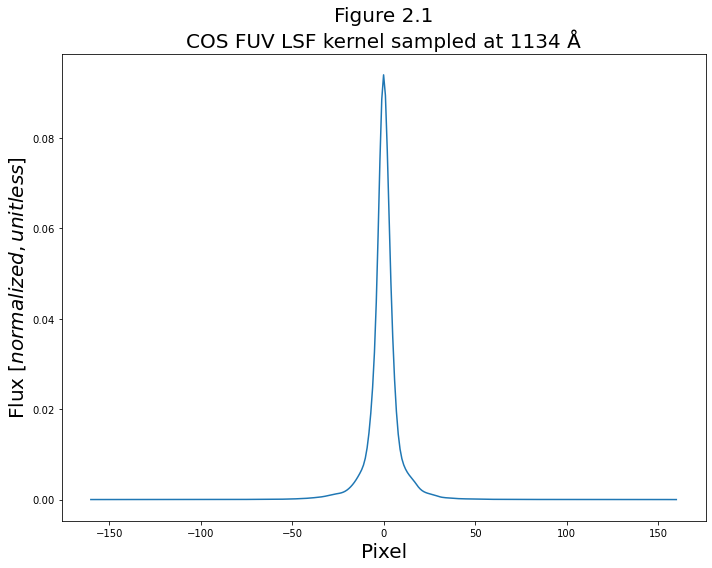

In [10]:
# Set up the figure
plt.figure(figsize = (10,8))
# Fill the figure with a plot of the data
plt.plot(pix, lsf['1134'])
# Give fig the title and labels
plt.title("Figure 2.1\nCOS FUV LSF kernel sampled at 1134 Å", size = 20)
plt.xlabel("Pixel", size = 20)
plt.ylabel("Flux [$normalized,unitless$]", size = 20)
# format and save the figure
plt.tight_layout()
plt.savefig(plotsdir + 'oneKernel.png', bbox_inches = 'tight')

#### We'll now make a more complex plot showing all of the lines contained in the LSF file, distributed in wavelength space
*Note* that while the centers of the lines are correctly mapped to the LSF wavelength at which they were sampled, their kernel width *in pixels* has only been roughly translated to a wavelength range in Å. In short, the x-axis is not strictly to-scale. This will be rectified by the remapping shown in Fig 3.1.

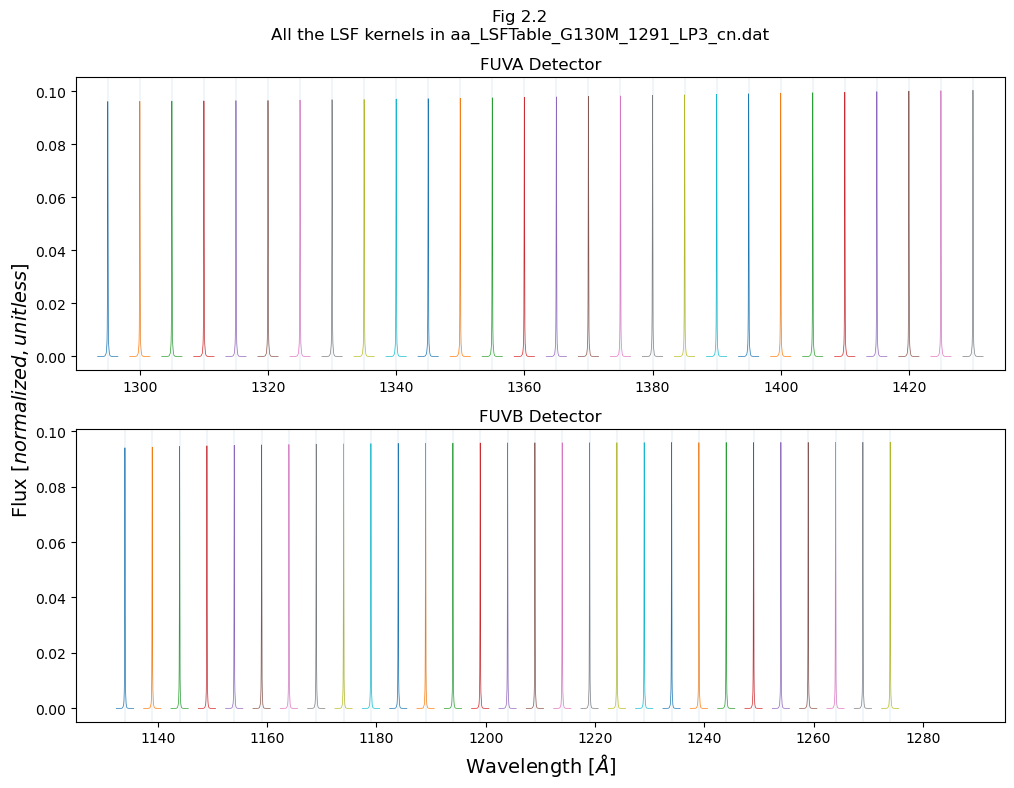

In [11]:
fig, (ax0,ax1) = plt.subplots(2,1, figsize = (10,8), dpi = 100)

# Loop through the lsf kernels
for i, col in enumerate(lsf.colnames):
    line_wvln = int(col) # central position
    contents = lsf[col].data # actual shape
    if line_wvln < 1291: # split into the FUVB segment
        xrange = (0.0099*pix + line_wvln) # ROUGHLY convert pix to wvln
        ax1.plot(xrange , contents, linewidth = 0.5) # Plot the kernel
        ax1.axvline(line_wvln, linewidth = 0.1) # plot the LSF wvln as a faded line
    elif line_wvln > 1291: # split into the FUVA segment
        xrange = (0.0099*pix + line_wvln) # ROUGHLY convert pix to wvln
        ax0.plot(xrange , contents, linewidth = 0.5) # Plot the kernel
        ax0.axvline(line_wvln, linewidth = 0.1) # plot the LSF wvln as a faded line
ax0.set_xlim(1290,1435)
ax1.set_xlim(1125,1295)
# Add labels, titles and text
fig.suptitle(f"Fig 2.2\nAll the LSF kernels in {LSF_file_name}")
ax1.set_title("FUVB Detector")
ax0.set_title("FUVA Detector")
ax1.set_xlabel("Wavelength [$\AA$]", size = 14)
fig.text(s = "Flux [$normalized,unitless$]", x = -0.01, y = 0.35, rotation = 'vertical' , size = 14)

# format and save the figure
plt.tight_layout()
plt.savefig(plotsdir + 'allKernels.png', bbox_inches = 'tight')

<a id = convL></a>
# 3. Convolving an LSF

Now we come to the central point of the notebook, convolving a spectrum with the COS LSF. We'll begin by defining some functions we'll use for the convolution.

<a id = funcL></a>
## 3.1. Defining some functions for LSF convolution

We've already defined a function to read in the LSF file, but we'll need the main function to take a spectrum and convolve it with the LSF kernel. We'll call this function:`convolve_lsf`. This function will, in turn, call two short functions: `get_disp_params` to and `redefine_lsf`:

<a id = fndispL></a>
### 3.1.1. Getting the dispersion relationship parameters
### First, we'll define a function, `get_disp_params`, to interpret the DISPTAB to find the dispersion relationship.
If provided with a range of pixel values, it will apply the dispersion relationship to those values and return the equivalent wavelength values as well as the dispersion coefficients.

In [12]:
def get_disp_params(disptab, cenwave, segment, x=[]):
    """
    Helper function to redefine_lsf(). Reads through a DISPTAB file and gives relevant\
    dispersion relationship/wavelength solution over input pixels.
    Parameters:
    disptab (str): Path to your DISPTAB file.
    cenwave (str): Cenwave for calculation of dispersion relationship.
    segment (str): FUVA or FUVB?
    x (list): Range in pixels over which to calculate wvln with dispersion relationship (optional).
    Returns:
    disp_coeff (list): Coefficients of the relevant polynomial dispersion relationship
    wavelength (list; if applicable): Wavelengths corresponding to input x pixels 
    """
    with fits.open(disptab) as d:
        wh_disp= np.where((d[1].data['cenwave'] == cenwave) &
                          (d[1].data['segment'] == segment) &
                          (d[1].data['aperture'] == 'PSA'))[0]
        disp_coeff = d[1].data[wh_disp]['COEFF'][0] # for some reason this returns nested list [[arr]]
        d_tv03 = d[1].data[wh_disp]['D_TV03'] # Offset from WCA to PSA in Thermal Vac. 2003 data
        d_orbit = d[1].data[wh_disp]['D'] # Current offset from WCA to PSA

    delta_d = d_tv03 - d_orbit

    if len(x): # If given a pixel range, build up a polynomial wvln solution pix -> λ
        wavelength = np.polyval(p=disp_coeff[::-1], x = np.arange(16384))
        return disp_coeff, wavelength
    else: # If x is empty:
        return disp_coeff

In [13]:
#### NUV:
pl = Observations.get_product_list(Observations.query_criteria(obs_id = 'LBY606010')) # search for file, generate data product list
download = Observations.download_products(pl[pl['productSubGroupDescription']=='X1DSUM'], # filter and download searched files
                                          download_dir = datadir)
nuvFile = download['Local Path'][0]# Give the program the path to your downloaded data

In [17]:
#### NUV:
nuvHeader0 = fits.getheader(nuvFile, ext = 0) # Grab the primary header
print(f"For the file {nuvFile}, the relevant parameters are: ")
nuv_param_dict = {} # Make a dict to store what you find here

for hdrKeyword in ['DETECTOR', 'OPT_ELEM', 'LIFE_ADJ', 'CENWAVE', 'DISPTAB']: # print out the relevant values
    try: # For DISPTAB
        value = nuvHeader0[hdrKeyword].split('$')[1] # Save the key/value pairs to the dictionary, DISPTAB needs the split
        nuv_param_dict[hdrKeyword] = value
    except: # For other params
        value = nuvHeader0[hdrKeyword] # Save the key/value pairs to the dictionary
        nuv_param_dict[hdrKeyword] = value
    print(f"{hdrKeyword} = {value}") # Print the key/value pairs

For the file ./data/mastDownload/HST/lby606010/lby606010_x1dsum.fits, the relevant parameters are: 
DETECTOR = NUV
OPT_ELEM = G185M
LIFE_ADJ = 1
CENWAVE = 1921
DISPTAB = 12e1345gl_disp.fits


In [18]:
#### NUV:
# We'll pass that fetch function the parameters we determined earlier
# This phrasing works because of the order in which we added the params to the dict
nuv_LSF_file_name, nuv_disptab_path = fetch_files(*list(nuv_param_dict.values())) 

Downloaded LSF file to ./data/nuv_model_lsf.dat
Downloaded DISPTAB file to ./data/12e1345gl_disp.fits


In [32]:
#### NUV:
# read_lsf(datadir+nuv_LSF_file_name)
lsf = Table.read(datadir+nuv_LSF_file_name, format='ascii', header_start=1)

In [48]:
#### NUV:
nlsf, npix, nlsf_wvlns = read_lsf(datadir+nuv_LSF_file_name)
len(nlsf), nuv_LSF_file_name

(302, 'nuv_model_lsf.dat')

col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
-50.1667,7.221e-05,7.17e-05,6.939e-05,6.723e-05,6.984e-05,8.028e-05,8.217e-05,9.12e-05,9.141e-05,9.288e-05,0.0001014,0.00011196,0.00011415,0.00012201,0.00014373,0.0001653
-49.8333,7.017e-05,6.744e-05,6.627e-05,6.546e-05,6.978e-05,7.677e-05,7.752e-05,8.847e-05,8.865e-05,9.021e-05,0.00010089,0.00011331,0.00011334,0.00012618,0.000144,0.00017064
-49.5,6.987e-05,6.576e-05,6.555e-05,6.636e-05,7.113e-05,7.539e-05,7.767e-05,8.781e-05,8.814e-05,9.246e-05,0.000102,0.00011532,0.00011538,0.00013302,0.00014973,0.00017943
-49.1667,7.05e-05,6.621e-05,6.633e-05,6.84e-05,7.272e-05,7.53e-05,8.07e-05,8.811e-05,8.88e-05,9.723e-05,0.00010461,0.00011718,0.00011943,0.00013911,0.00015744,0.00018834
-48.8333,7.149e-05,6.813e-05,6.738e-05,7.023e-05,7.431e-05,7.581e-05,8.502e-05,8.913e-05,8.988e-05,0.00010221,0.00010905,0.00011898,0.00012447,0.00014364,0.00016608,0.00019533
-48.5,7.293e-05,7.092e-05,6.825e-05,7.17e-05,7.623e-05,7.677e-05,8.943e-05,9.102e-05,9.156e-05,0.00010638,0.0001152,0.00012123,0.00013053,0.00014898,0.00017625,0.00020097
-48.1667,7.491e-05,7.377e-05,6.93e-05,7.344e-05,7.866e-05,7.851e-05,9.321e-05,9.345e-05,9.462e-05,0.00010986,0.00012183,0.00012429,0.00013818,0.00015714,0.00018783,0.00020721
-47.8333,7.698e-05,7.581e-05,7.098e-05,7.596e-05,8.136e-05,8.142e-05,9.618e-05,9.594e-05,9.951e-05,0.00011289,0.00012729,0.00012831,0.00014661,0.0001671,0.00019953,0.00021357
-47.5,7.854e-05,7.689e-05,7.353e-05,7.926e-05,8.376e-05,8.547e-05,9.828e-05,9.828e-05,0.00010572,0.00011619,0.00013095,0.00013317,0.00015381,0.00017724,0.00020937,0.00021804


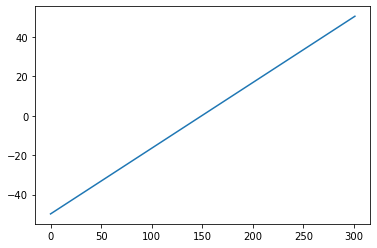

In [57]:
#### NUV:
plt.plot(nlsf.columns[0])

In [92]:
#### NUV:

lsf = Table.read(datadir+nuv_LSF_file_name, format='ascii', header_start=None, names = np.arange(1700, 3300, 100), data_start=1)
with open(datadir+nuv_LSF_file_name) as f:
    for i,line in enumerate(f):
        if i ==1:
            print(line,line.split('    ')[1:])

InconsistentTableError: 
ERROR: Unable to guess table format with the guesses listed below:
Reader:Ecsv data_start: 1 fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) strict_names: True
Reader:FixedWidthTwoLine data_start: 1 fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) strict_names: True
Reader:RST data_start: 1 fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) strict_names: True
Reader:FastBasic data_start: 1 fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) strict_names: True
Reader:Basic data_start: 1 fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) strict_names: True
Reader:FastRdb data_start: 1 fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) strict_names: True
Reader:Rdb data_start: 1 fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) strict_names: True
Reader:FastTab data_start: 1 fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) strict_names: True
Reader:Tab data_start: 1 fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) strict_names: True
Reader:Cds data_start: 1 fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) strict_names: True
Reader:Daophot data_start: 1 fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) strict_names: True
Reader:SExtractor data_start: 1 fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) strict_names: True
Reader:Ipac data_start: 1 fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) strict_names: True
Reader:Latex data_start: 1 fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) strict_names: True
Reader:AASTex data_start: 1 fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) strict_names: True
Reader:FastCommentedHeader data_start: 1 delimiter: '|' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: '"' strict_names: True
Reader:FastCommentedHeader data_start: 1 delimiter: '|' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: "'" strict_names: True
Reader:FastCommentedHeader data_start: 1 delimiter: ',' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: '"' strict_names: True
Reader:FastCommentedHeader data_start: 1 delimiter: ',' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: "'" strict_names: True
Reader:FastCommentedHeader data_start: 1 delimiter: ' ' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: '"' strict_names: True
Reader:FastCommentedHeader data_start: 1 delimiter: ' ' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: "'" strict_names: True
Reader:FastCommentedHeader data_start: 1 delimiter: '\\s' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: '"' strict_names: True
Reader:FastCommentedHeader data_start: 1 delimiter: '\\s' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: "'" strict_names: True
Reader:CommentedHeader data_start: 1 delimiter: '|' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: '"' strict_names: True
Reader:CommentedHeader data_start: 1 delimiter: '|' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: "'" strict_names: True
Reader:CommentedHeader data_start: 1 delimiter: ',' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: '"' strict_names: True
Reader:CommentedHeader data_start: 1 delimiter: ',' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: "'" strict_names: True
Reader:CommentedHeader data_start: 1 delimiter: ' ' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: '"' strict_names: True
Reader:CommentedHeader data_start: 1 delimiter: ' ' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: "'" strict_names: True
Reader:CommentedHeader data_start: 1 delimiter: '\\s' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: '"' strict_names: True
Reader:CommentedHeader data_start: 1 delimiter: '\\s' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: "'" strict_names: True
Reader:FastBasic data_start: 1 delimiter: '|' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: '"' strict_names: True
Reader:FastBasic data_start: 1 delimiter: '|' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: "'" strict_names: True
Reader:FastBasic data_start: 1 delimiter: ',' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: '"' strict_names: True
Reader:FastBasic data_start: 1 delimiter: ',' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: "'" strict_names: True
Reader:FastBasic data_start: 1 delimiter: ' ' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: '"' strict_names: True
Reader:FastBasic data_start: 1 delimiter: ' ' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: "'" strict_names: True
Reader:FastBasic data_start: 1 delimiter: '\\s' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: '"' strict_names: True
Reader:FastBasic data_start: 1 delimiter: '\\s' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: "'" strict_names: True
Reader:Basic data_start: 1 delimiter: '|' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: '"' strict_names: True
Reader:Basic data_start: 1 delimiter: '|' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: "'" strict_names: True
Reader:Basic data_start: 1 delimiter: ',' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: '"' strict_names: True
Reader:Basic data_start: 1 delimiter: ',' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: "'" strict_names: True
Reader:Basic data_start: 1 delimiter: ' ' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: '"' strict_names: True
Reader:Basic data_start: 1 delimiter: ' ' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: "'" strict_names: True
Reader:Basic data_start: 1 delimiter: '\\s' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: '"' strict_names: True
Reader:Basic data_start: 1 delimiter: '\\s' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: "'" strict_names: True
Reader:FastNoHeader data_start: 1 delimiter: '|' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: '"' strict_names: True
Reader:FastNoHeader data_start: 1 delimiter: '|' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: "'" strict_names: True
Reader:FastNoHeader data_start: 1 delimiter: ',' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: '"' strict_names: True
Reader:FastNoHeader data_start: 1 delimiter: ',' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: "'" strict_names: True
Reader:FastNoHeader data_start: 1 delimiter: ' ' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: '"' strict_names: True
Reader:FastNoHeader data_start: 1 delimiter: ' ' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: "'" strict_names: True
Reader:FastNoHeader data_start: 1 delimiter: '\\s' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: '"' strict_names: True
Reader:FastNoHeader data_start: 1 delimiter: '\\s' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: "'" strict_names: True
Reader:NoHeader data_start: 1 delimiter: '|' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: '"' strict_names: True
Reader:NoHeader data_start: 1 delimiter: '|' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: "'" strict_names: True
Reader:NoHeader data_start: 1 delimiter: ',' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: '"' strict_names: True
Reader:NoHeader data_start: 1 delimiter: ',' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: "'" strict_names: True
Reader:NoHeader data_start: 1 delimiter: ' ' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: '"' strict_names: True
Reader:NoHeader data_start: 1 delimiter: ' ' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: "'" strict_names: True
Reader:NoHeader data_start: 1 delimiter: '\\s' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: '"' strict_names: True
Reader:NoHeader data_start: 1 delimiter: '\\s' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200]) quotechar: "'" strict_names: True
Reader:Basic data_start: 1 fast_reader: {'enable': True} fill_values: [('', '0')] header_start: None names: array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200])

************************************************************************
** ERROR: Unable to guess table format with the guesses listed above. **
**                                                                    **
** To figure out why the table did not read, use guess=False and      **
** fast_reader=False, along with any appropriate arguments to read(). **
** In particular specify the format and any known attributes like the **
** delimiter.                                                         **
************************************************************************

In [91]:
np.arange(1700, 3300, 100)

array([1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200])

<a id="fnredefL"></a>
### 3.1.2. Redefining the LSF in terms of wavelength

### Now, we'll define a function, `redefine_lsf`, to apply the dispersion relationship to the LSF kernels.
This effectively converts an LSF kernel from a function of pixel to a function of wavelength, making it compatible with a spectrum. This function has currently only been implemented for working with FUV data.

In [ ]:
def redefine_lsf(lsf_file, cenwave, disptab, detector='FUV'):
    """
    Helper function to convolve_lsf(). Converts the LSF kernels in the LSF file from a fn(pixel) -> fn(λ)\
    which can then be used by convolve_lsf() and re-bins the kernels. Only works for FUV.
    Parameters:
    lsf_file (str): path to your LSF file
    cenwave (str): Cenwave for calculation of dispersion relationship
    disptab (str): path to your DISPTAB file
    detector (str): FUV or NUV? (only FUV is implemented, assumed FUV)
    Returns:
    new_lsf (numpy.ndarray): Remapped LSF kernels.
    new_w (numpy.ndarray): New LSF kernel's LSF wavelengths.
    step (float): first order coefficient of the FUVA dispersion relationship; proxy for Δλ/Δpixel.
    """
    
    
    if detector == 'FUV':
        # Works with FUV detector only at present
        xfull = np.arange(16384)

    elif detector == 'NUV':
        raise NotImplementedError()
        xfull = np.arange(1024)

    # Read in the dispersion relationship here for the segments 
    ### FUVA is simple
    disp_coeff_a, wavelength_a = get_disp_params(disptab, cenwave, 'FUVA', x=xfull)
    ### FUVB isn't taken for cenwave 1105
    if cenwave != 1105:
        disp_coeff_b, wavelength_b = get_disp_params(disptab, cenwave, 'FUVB', x=xfull)
    elif cenwave == 1105:
        # 1105 doesn't have an FUVB so set it to something arbitrary, clearly not real:
        wavelength_b = [-99., 0.]

    # Get the step size info from the FUVA 1st order dispersion coefficient
    step = disp_coeff_a[1] 

    # Read in the lsf file
    lsf, pix, w = read_lsf(lsf_file)

    # take median spacing between original LSF kernels
    deltaw = np.median(np.diff(w))
    
    lsf_array = [np.array(lsf[key]) for key in lsf.keys()] 
    if deltaw > len(pix)*step*2: # makes sure the spacing of the original LSF wvlns is not too wide
        raise ValueError('deltaw too large:\ndeltaw:{}\nthreshold:{}'.format(deltaw, len(pix)*step*2))

    # this is all a set up of the bins we want to use
    new_deltaw = round(len(pix)*step*2.) # The wvln difference between kernels of the new LSF should be about twice their width
    new_nw = int(round((max(w)-min(w))/new_deltaw))+1 # nw = number of LSF wavelengths
    new_w = min(w) + np.arange(new_nw)*new_deltaw # new version of lsf_wvlns

    # populating the lsf with the proper bins
    new_lsf = np.zeros((len(pix), new_nw)) #empty 2-D array to populate
    for i, current_w in enumerate(new_w):
        dist = abs(current_w - w) # Find closest original LSF wavelength to new LSF wavelength
        lsf_index = np.argmin(dist)
        orig_lsf_wvln_key = lsf.keys()[lsf_index] # column name corresponding to closest orig LSF wvln
        new_lsf[:, i] = np.array(lsf[orig_lsf_wvln_key]) # assign new LSF wvln the kernel of the closest original lsf wvln
    return new_lsf, new_w, step

In [ ]:
new_lsf, new_w, step = redefine_lsf(datadir+LSF_file_name, param_dict['CENWAVE'], datadir+param_dict['DISPTAB'])

### Let's make a version of Fig. 2.2 with these newly remapped LSF kernels:

In [ ]:
fig, (ax0,ax1) = plt.subplots(2,1, figsize = (10,8), dpi = 100)

# Loop through the NEW remapped lsf kernels
for i, col in enumerate(new_w):
    line_wvln = int(col) # central position
    contents = new_lsf[:,i] # actual shape
    if line_wvln < 1291: # split into the FUVB segment
        xrange = (new_w[i] + pix*step) # ROUGHLY convert pix to wvln
        ax1.plot(xrange , contents, linewidth = 0.5) # Plot the kernel
        ax1.axvline(line_wvln, linewidth = 0.1) # plot the LSF wvln as a faded line
    elif line_wvln > 1291: # split into the FUVA segment
        xrange = (new_w[i] + pix*step) # ROUGHLY convert pix to wvln
        ax0.plot(xrange , contents, linewidth = 0.5) # Plot the kernel
        ax0.axvline(line_wvln, linewidth = 0.1) # plot the LSF wvln as a faded line

# Add labels, titles and text
fig.suptitle(f"Fig 3.1\nAll the $remapped$ LSF kernels in {LSF_file_name}\n")
ax1.set_title("FUVB Detector")
ax0.set_title("FUVA Detector")
ax0.set_xlim(1290,1435)
ax1.set_xlim(1125,1295)

ax1.set_xlabel("Wavelength [$\AA$]", size = 14)
fig.text(s = "Flux [$normalized,unitless$]", x = -0.01, y = 0.35, rotation = 'vertical' , size = 14)

# format and save the figure
plt.tight_layout()
plt.savefig(plotsdir + 'allKernels_new.png', bbox_inches = 'tight')

<a id = fnconvL></a>
### 3.1.3. Applying the convolution

### Finally, we'll define the main function, `convolve_lsf`, to convolve the template spectrum with the redefined LSF:



In [ ]:
def convolve_lsf(wavelength, spec, cenwave, lsf_file, disptab):
    """
    Main function; Convolves an input spectrum - i.e. template or STIS spectrum - with the COS LSF.
    Parameters:
    wavelength (list or array): Wavelengths of the spectrum to convolve.
    spec (list or array): Fluxes or intensities of the spectrum to convolve.
    cenwave (str): Cenwave for calculation of dispersion relationship
    lsf_file (str): Path to your LSF file
    disptab (str): Path to your DISPTAB file
    Returns:
    wave_cos (numpy.ndarray): Wavelengths of convolved spectrum.!Different length from input wvln
    final_spec (numpy.ndarray): New LSF kernel's LSF wavelengths.!Different length from input spec
    """
    # First calls redefine to get right format of LSF kernels 
    new_lsf, new_w, step = redefine_lsf(lsf_file, cenwave, disptab)

    # sets up new wavelength scale used in the convolution
    nstep = round(( max(wavelength)-min(wavelength))/step)-1
    wave_cos = min(wavelength) + np.arange(nstep)*step

    # resampling onto the input spectrum's wavelength scale
    interp_func = interp1d(wavelength, spec) # builds up interpolated function from input spectrum
    spec_cos    = interp_func(wave_cos) # builds interpolated initial spectrum at COS' wavelength scale for convolution
    final_spec  = interp_func(wave_cos) # Initializes final spectrum to the interpolated input spectrum

    
    for i, w in enumerate(new_w): # Loop through the redefined LSF kernels
        # First need to find the boundaries of each kernel's "jurisdiction"
        # The first and last elements need to be treated separately
        if i == 0:              # First kernel
            diff_wave_left = 500
            diff_wave_right = (new_w[i+1]-w)/2.
        elif i == len(new_w)-1: # Last kernel
            diff_wave_right = 500
            diff_wave_left = (w-new_w[i-1])/2.
        else:                   # All other kernels
            diff_wave_left = (w-new_w[i-1])/2.
            diff_wave_right = (new_w[i+1]-w)/2.
 
        # splitting up the spectrum into slices around the redefined LSF kernel wvlns
        # will apply the kernel corresponding to that chunk to that region of the spectrum - its "jurisdiction"
        chunk = np.where( (wave_cos < w+diff_wave_right) &
                        (wave_cos >= w-diff_wave_left))[0]
        if len(chunk) == 0:
            # off the edge, go to the next chunk
            continue

        current_lsf = new_lsf[:, i] # selects the current kernel 

        if len(chunk) >= len(current_lsf): # Makes sure that the kernel is smaller than the chunk
            final_spec[chunk] = convolve(spec_cos[chunk], current_lsf, # Applies the actual convolution
                                         boundary="extend", normalize_kernel=True)

    return wave_cos, final_spec # Remember, not the same length as input spectrum data!

<a id = picketL></a>
## 3.2. Convolving simple line profiles

### Let's demonstrate the convolution with a quick initial plot.
The cell below first creates a simple synthetic spectrum (with a wavelength range from 1147-1153Å and a Voigt profile line at 1150Å), then convolves it with the COS LSF. It then plots the two spectra together.

In [ ]:
##### Generate data:
# Define a model spectral line with a Voigt profile
voigt_shape = functional_models.Voigt1D(x_0 = 1150, amplitude_L = 1, fwhm_G = .1, fwhm_L = 0.1) 
# Make a simple spectrum with just that line at 1150 Å
wvln_in = np.linspace(1147,1153, int(1E5)) # generate x data - Minimum size of Δ6Å for the kernel to apply here.
spec_in = voigt_shape(wvln_in) # Generate the y data
spec_in /= max(spec_in) # Normalize the y data to a max of 1
### Run the convolution
wvln_out, spec_out = convolve_lsf(wvln_in, spec_in, 1291, datadir+LSF_file_name, datadir+param_dict['DISPTAB'])
############################################################################################
##### Make a plot from that data:
plt.figure(figsize = (10,8)) # Set up figure
# Plot the two spectra
plt.plot(wvln_in, spec_in, label = "Un-Convolved Voigt line spectrum")
plt.plot(wvln_out, spec_out, linestyle = '--', linewidth = 2,
         c = 'k', label = "Convolved Voigt line spectrum")
# Add a legend
plt.legend(fontsize = 12, loc = 'upper right')
# Give fig the title and labels
plt.title("Figure 3.2\nConvolution applied to a single synthetic line", size = 20)
plt.xlabel("Pixel", size = 20)
plt.ylabel("Flux [$normalized,unitless$]", size = 20)
# format and save the figure
plt.tight_layout()
plt.savefig(plotsdir + 'applyConv1.png', bbox_inches = 'tight')

#### As shown above, the LSF pushes power from the line's peak into the wings of the line profile.
As we confirm below, the total flux has not changed, but has just been spread out:

In [ ]:
integral1,integral2 = np.trapz(x = wvln_in, y = spec_in),np.trapz(x = wvln_out, y = spec_out)
print(f"The integrated fluxes are within {100* (integral1-integral2)/integral2:.2f} % of eachother")

### We can now examine how the convolution differs across the spectrum.
We do this by creating a ["picket fence"/"frequency comb"](https://en.wikipedia.org/wiki/Frequency_comb)-like spectrum of evenly-spaced, identical, normalized Voigt profiles. Each of these lines is normalized to a maximum of 1. We then use `convolve_lsf` to convolve each of these synthetic spectral lines with the LSF kernel under whose "jurisdiction" they fall. For each line, we plot *pre-* and *post-* convolution spectrum in the 8 smaller panels. In the bottom, larger panel, we also plot the entire spectrum of all the lines.

In [ ]:
########## Set up the DATA ##############

wvln = np.linspace(1120,1442, 16384 * 2) # Build up a synthetic wavelength range comparable to a real COS spectrum
flux = np.zeros(wvln.shape) # Initialize the spectrum to zero, we'll build it up with a series of Voigt profiles
combo_flux = flux # A copy of flux that we'll add each new line's flux to, in turn

# Set up figure
fig = plt.figure(figsize = (20, 15))
gs = fig.add_gridspec(nrows = 10, ncols = 4) # Using gridspec to let us control panel sizes and locations

# Loop through the input spectrum's wavelength range and place a synthetic Voigt line every 40 Å
for i, discrete_wvln in enumerate(np.arange(int(min(wvln)+5), max(wvln)-5, 40)):
    voigt_shape = functional_models.Voigt1D(x_0 = discrete_wvln, # Center a Voigt profile there
        amplitude_L = 1, fwhm_G = .1, fwhm_L = 0.1)
    flux = voigt_shape(wvln) # evaluate flux from that Voigt profile function
    flux /= max(flux) # Normalize that line's flux
    combo_flux = combo_flux + flux # Add each line's flux to total summed flux

# Apply the convolution to the combined (many-line) synthetic spectrum to create an lsf_convolved wvln and flux
lwvln, lsf_combo_flux = convolve_lsf(wvln, combo_flux, 1291, datadir + LSF_file_name , datadir + param_dict['DISPTAB'])

########## Make the PLOTS ##############

# Loop through again to build up the plots
for i, discrete_wvln in enumerate(np.arange(int(min(wvln)+5), max(wvln)-5, 40)): # This will make 8 subplots
    ###### Build the small subplots for each line
    ax = fig.add_subplot(gs[4*int(i/4):4*int(i/4) + 4, i%4:(i)%4 + 1]) # Add a plot at the right position on the grid
    ax.plot(wvln, combo_flux, label = 'Un-convolved') # First plot the original, unconvolved line at each position
    ax.plot(lwvln, lsf_combo_flux, c = 'k', linestyle = '--', linewidth = 2, label = 'LSF-convolved') # now the convolved line
    ax.axvline(discrete_wvln, c = 'C1', linestyle = 'dotted', alpha = 0.8, label = 'Peak of Voigt') # add the peak wvln
    ax.set_xlim(discrete_wvln-0.5, discrete_wvln+0.5)
    ax.ticklabel_format(axis = 'x', style = 'plain', useOffset = True, useMathText = True)
    if i == 0: # Add a legend to the first subplot
        ax.legend(fontsize = 12, loc = 'upper left')

# Build up lower plot of all the lines:
low_ax = fig.add_subplot(gs[8:,:])
low_ax.plot(wvln, combo_flux, label = 'Un-convolved')
low_ax.plot(lwvln, lsf_combo_flux, c = 'k', linestyle = '--', label = 'LSF-convolved')
low_ax.legend(fontsize = 14, loc = 'upper right')

fig.suptitle("Fig 3.3\nComparison of convolutions across a \"picket fence\" of lines\n", size = 25)

fig.text(0.5, -0.01, 'Wavelength [$\AA$]', ha='center', fontsize = 20)
fig.text(-0.01, 0.5, 'Flux [$normalized,\ unitless$]', va='center', rotation='vertical', fontsize = 20)

plt.tight_layout()
plt.savefig(plotsdir + 'applyConv_picketFence.png', bbox_inches='tight', dpi = 200)

### The above figure demonstrates the way in which the LSF changes significantly throughout the wavelength range of a spectrum.
It can be difficult to distinguish the LSFs plotted on their own; however, the results of their convolution with a synthetic line shows some are more sharply peaked, or contain more flux in the wings, etc.

<a id = stisL></a>
## 3.3. Convolving real data from STIS

##### Let's first read in the COS spectrum. For more information, see our notebook on [Reading-in and Plotting data COS in Python](https://spacetelescope.github.io/COS-Notebooks/ViewData.html).

In [ ]:
cos_table = Table.read(fuvFile)
COS_wvln, COS_flux = [],[]
for cos_segment in [1,0]: # The COS segment at index 0 has a longer wvln domain
    COS_wvln_, COS_flux_ = list(cos_table[cos_segment]['WAVELENGTH','FLUX'])
    COS_dqw_ = np.asarray(cos_table[cos_segment]['DQ_WGT'], dtype = bool)
    COS_wvln+=(list(COS_wvln_[COS_dqw_]))
    COS_flux+=(list(COS_flux_[COS_dqw_]))
COS_wvln, COS_flux = np.asarray(COS_wvln), np.asarray(COS_flux)

##### Now, download the STIS spectrum, using astroquery, as demonstrated in our notebook on [Downloading data from the archive](https://spacetelescope.github.io/COS-Notebooks/DataDl.html).

In [ ]:
pl = Observations.get_product_list(Observations.query_criteria(obs_id = 'O4WR11010', instrument_name = 'STIS/FUV-MAMA')) # search for the file
download = Observations.download_products(pl[pl['productSubGroupDescription']=='X1D'], # filter and download searched files
                                          download_dir = datadir)
stisfile = download['Local Path'][0]# Give the program the path to your downloaded data

##### Read in the STIS spectrum.
This is a bit trickier than with the COS data, as there are many more segments of the STIS data (one per echelle order), each represented by a row of the table. We choose to combine them all here and sort by wavelength, but this may or may not be the right choice for your data. For more information on working with STIS data, see the [STIS Instrument Handbook](https://hst-docs.stsci.edu/stisdhb).

In [ ]:
stis_table = Table.read(stisfile) # read the fits to an astropy Table
STIS_wvln, STIS_flux = [],[] # Empty list to populate

for i in range(len(stis_table)): # go through Echelle order rows + populate
    stis_chunk_mask = stis_table['DQ'][i] == 0 # We'll filter to only data with no identified quality issues
    STIS_wvln += list(stis_table['WAVELENGTH'][i][stis_chunk_mask])
    STIS_flux += list(stis_table['FLUX'][i][stis_chunk_mask])
sort_order = np.argsort(STIS_wvln) # sort by wvln to work out order overlaps - blunt fix
STIS_wvln, STIS_flux = np.asarray(STIS_wvln)[sort_order], np.asarray(STIS_flux)[sort_order] # Get STIS spec as sorted array

In [ ]:
# Run the actual convolution on the STIS data - a simple task once we have those functions defined
STIS_lwvln, STIS_lflux = convolve_lsf(STIS_wvln, STIS_flux, 1291, 
                                      datadir + LSF_file_name , datadir + param_dict['DISPTAB'])

#### We'll plot the COS spectra with the STIS spectra, (both pre- and post- convolution,) to demonstrate the effect on our data.
We'll first plot the entire spectrum:

In [ ]:
# Set up figure
plt.figure(figsize = (10,8))

# Plot each of the spectra
plt.plot(STIS_wvln, STIS_flux, linestyle = '-', c = 'C0',
            label = "STIS Un-convolved")
plt.plot(STIS_lwvln, STIS_lflux, markersize = 1, linestyle = '-', c = 'C1',
            label = "STIS Convolved")
plt.plot(COS_wvln, COS_flux, markersize = 0.1, linestyle = '-', c ='k', alpha = 0.8,
            label = "COS")
# Set ybounds to avoid spike at shorter λ side
plt.ylim(-1E-13, 1E-12)
#Add a legend
plt.legend(fontsize = 15, loc = 'upper right')
# Give fig the title and labels
plt.title("Figure 3.4\nCOS FUV LSF kernel sampled at 1134 Å", size = 20)
plt.xlabel("Wavelength [$\AA$]", size = 20)
plt.ylabel("Flux [$erg\ \AA^{-1}\ cm^{-2}\ s^{-1}$]", size = 20)
# format and save the figure
plt.tight_layout()
plt.savefig(plotsdir + 'COS_STIS_compare_wide.png', bbox_inches = 'tight')

We can tell that the peaks have been cut shorter in the STIS convolved spectrum.

However, to see a bit more detail, let's make plots zooming in on spectral lines. We arbitrarily grabbed a few spectral lines in the UV from Table 1 of [Leitherer et al.'s "An ultraviolet spectroscopic atlas of local starbursts and star-forming galaxies: the legacy of FOS and GHRS." The Astronomical Journal 141, no. 2 (2011): 37.](https://iopscience.iop.org/article/10.1088/0004-6256/141/2/37/meta)

In [ ]:
# Grab a few UV lines from the table in Leitherer et al, 2011
lines = {"S II":1250.58, "Si II":1304.37, "C II":1335.71, "Si IV":1393.76}

# Set up figure
fig = plt.figure(figsize = (10, 16))
gs = fig.add_gridspec(nrows = 4, ncols = 1) # Using gridspec to let us control panel sizes and locations

for i, (linename, line) in enumerate(lines.items()): # For each line:
    
    ax = fig.add_subplot(gs[i,0]) # Add a plot at the correct position on the grid

    ax.plot(STIS_wvln, STIS_flux, linestyle = '-.', c = 'C0', # Plot all the spectra for each line
                label = "STIS Un-convolved")
    ax.plot(STIS_lwvln, STIS_lflux, markersize = 1, linestyle = '-', c = 'C1',
                label = "STIS Convolved")
    ax.plot(COS_wvln, COS_flux, markersize = 0.1, linestyle = '--', c ='k', 
                label = "COS")
    # Add a vertical line at the reference frame wavelength of the line
    ax.axvline(line, c = 'gray', linestyle = '--', label = f"{linename} line at {line}Å")
    
    # Set bounds and add legends
    ax.set_xlim(line - 1, line + 1)
    ax.set_ylim(-1E-13, 1E-12)
    ax.legend(fontsize = 15, loc = 'upper right')

# Give fig the title and labels
fig.suptitle(f"Fig. 3.5\nA series of UV lines with COS\n and STIS spectra convolved with COS LSFs\n", size = 20)
ax.set_xlabel("Wavelength [$\AA$]", size = 20)
fig.text(s = "Flux [$erg\ \AA^{-1}\ cm^{-2}\ s^{-1}$]", x = -0.018, y = 0.4, rotation = 'vertical' , size = 20)

# format and save the figure
plt.tight_layout()
plt.savefig(plotsdir + 'COS_STIS_compare.png', bbox_inches = 'tight')

## Congratulations! You finished this notebook!
### There are more COS data walkthrough notebooks on different topics. You can find them [here](https://github.com/spacetelescope/COS-Notebooks).


---
## About this Notebook
**Author:** Nat Kerman <nkerman@stsci.edu>

**Contributors:** Rachel Plesha, Julia Roman-Duval

**Updated On:** 2021-02-01

> *This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*

## Citations

If you use `astropy`, `matplotlib`, `astroquery`, or `numpy` for published research, please cite the
authors. Follow these links for more information about citations:

* [Citing `astropy`/`numpy`/`matplotlib`](https://www.scipy.org/citing.html)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)

---

[Top of Page](#topL)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 

<br></br>
<br></br>
<br></br>